# Intro to RML with MPoL

In this tutorial, we'll construct an optimization loop demonstrating how we can use MPoL to synthesize a basic image. We'll continue with the dataset described in the [Gridding and Diagnostic Images](gridder.md) tutorial.

## Gridding recap
Let's set up the {class}`~mpol.gridding.DataAverager` and {class}`~mpol.coordinates.GridCoords` objects as before


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from astropy.utils.data import download_file
from IPython.display import SVG, display

In [58]:
from mpol import coordinates, fourier, gridding, losses, precomposed, utils
from mpol.__init__ import zenodo_record

In [59]:
# fname = download_file(
#     f"https://zenodo.org/record/{zenodo_record}/files/logo_cube.noise.npz",
#     cache=True,
#     show_progress=True,
#     pkgname="mpol",
# )
fname = '../data/visibilities/RDor_spw0.split.fixvis.averaged_lambda_flags_removed_weights_rescaled.npz'
# this is a multi-channel dataset... for demonstration purposes we'll use
# only the central, single channel
chan = 0
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)


In [60]:
# define the image dimensions, as in the previous tutorial
coords = coordinates.GridCoords(cell_size=0.001, npix=128)
averager = gridding.DataAverager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data_re,
    data_im=data_im,
)

## The PyTorch dataset

### Cell-averaging
The visibility averaging step performed by the {class}`~mpol.gridding.DataAverager` is a weighted average that is numerically equivalent to "uniform" weighting of the visibilities; this does not mean that MPoL or RML only produces images that have "uniform" weighting, however. The {class}`~mpol.gridding.DataAverager` also propagates the uncertainties from the individual visibilities to an uncertainty on the averaged visibility cell. When MPoL *forward-models* the visibility dataset and evaluates model image against the data, these uncertainties are used in a likelihood function, which is combined with priors/regularizers and the numerical results will be the same whether or not the likelihood function is computed using the gridded or ungridded visibilities. By contrast, dirty images are a direct inverse Fourier transform of the gridded visibility data and depend on whether the visibilities were weighted with uniform, natural, or Briggs weighting schemes.


Now we will export the visibilities to a PyTorch dataset to use in the imaging loop. The {meth}`mpol.gridding.DataAverager.to_pytorch_dataset` routine performs a weighted average all of the visibilities to the Fourier grid cells and exports the visibilities to cube-like PyTorch tensors. To keep things simple in this tutorial, we are only using a single channel. But you could just as easily export a multi-channel dataset. Note that the {meth}`~mpol.gridding.DataAverager.to_pytorch_dataset` routine automatically checks the visibility scatter and raises a ``RuntimeError`` if the empirically-estimated scatter exceeds that expected from the provided dataset weights. For more information, see the end of the [Gridding and Diagnostic Images Tutorial](gridder.md).



In [61]:
dset = averager.to_pytorch_dataset()
print("this dataset has {:} channel".format(dset.nchan))

this dataset has 1 channel


## Building an image model

MPoL provides "modules" to build and optimize complex imaging workflows, not dissimilar to how a deep neural network might be constructed. We've bundled the most common modules for imaging together in a {class}`mpol.precomposed.GriddedNet` meta-module, which we'll use here.

This diagram shows how the primitive modules, like {class}`mpol.images.BaseCube`, {class}`mpol.images.ImageCube`, etc... are connected together to form {class}`mpol.precomposed.GriddedNet`. In this workflow, the pixel values of the {class}`mpol.images.BaseCube` are the core model parameters representing the image. More information about all of these components is available in the API documentation.


It isn't necessary to construct a meta-module to do RML imaging with MPoL, though it often helps organize your code. If we so desired, we could connect the individual modules together ourselves ourselves following the GriddedNet source code as an example ({class}`mpol.precomposed.GriddedNet`) and swap in/out modules as we saw fit.

We then initialize GriddedNet with the relevant information


In [62]:
rml = precomposed.GriddedNet(coords=coords, nchan=dset.nchan)

## Breaking down the training loop

Our goal for the rest of the tutorial is to set up a loop that will

1. evaluate the current model against a loss function
2. calculate the gradients of the loss w.r.t. the model
3. advance the model parameters in the direction to minimize the loss function

We'll start by creating the optimizer


In [63]:
optimizer = torch.optim.SGD(rml.parameters(), lr=3e4)

The role of the optimizer is to advance the parameters (in this case, the pixel values of the {class}`mpol.images.BaseCube` using the gradient of the loss function with respect to those parameters. PyTorch has many different [optimizers](https://pytorch.org/docs/stable/optim.html#module-torch.optim) available, and it is worthwhile to try out some of the different ones. Stochastic Gradient Descent (SGD) is one of the simplest, so we’ll start here. The `lr` parameter is the 'learning rate,' or how ambitious the optimizer should be in taking descent steps. Tuning this requires a bit of trial and error: you want the learning rate to be small enough so that the algorithm doesn’t diverge but large enough so that the optimization completes in a reasonable amount of time.


## Loss functions
In the parlance of the machine learning community, one defines "loss" functions comparing models to data. For regularized maximum likelihood imaging, the most fundamental loss function we'll use is the {func}`mpol.losses.loss_fn` or the $\chi^2$ value comparing the model visibilities to the data visibilities. For this introductory tutorial, we'll use only the data likelihood loss function to start, but you should know that because imaging is an ill-defined inverse problem, this is **not a sufficient constraint** by itself. In later tutorials, we will apply regularization to narrow the set of possible images towards ones that we believe are more realistic. The {mod}`mpol.losses` module contains several loss functions currently popular in the literature, so you can experiment to see which best suits your application.

## Gradient descent

Let's walk through how we calculate a loss value and optimize the parameters. To start, let's [examine the parameters of the model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)


In [64]:
rml.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[-3., -3., -3.,  ..., -3., -3., -3.],
                       [-3., -3., -3.,  ..., -3., -3., -3.],
                       [-3., -3., -3.,  ..., -3., -3., -3.],
                       ...,
                       [-3., -3., -3.,  ..., -3., -3., -3.],
                       [-3., -3., -3.,  ..., -3., -3., -3.],
                       [-3., -3., -3.,  ..., -3., -3., -3.]]])),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]])),
             ('conv_layer.m.bias', tensor([0.])),
             ('nufft.nufft_ob.table_0',
              tensor([ 0.0000e+00+0.0000e+00j, -2.9417e-07-7.6695e-06j,
                      -3.1558e-07-7.9130e-06j,  ...,
                      -3.1558e-07+7.9130e-06j, -2.9417e-07+7.6695e-06j,
                       0.0000e+00+0.0000e+00j])),
             ('nufft.nufft_ob.table_1',


These are the default values that were used to initialize the {class}`mpol.images.BaseCube` component of the {class}`mpol.precomposed.GriddedNet`.

For demonstration purposes, lets access and plot the base cube with matplotlib. In a normal workflow you probably won't need to do this, but to access the basecube in sky orientation, we do

In [65]:
bcube_pytorch = utils.packed_cube_to_sky_cube(rml.bcube.base_cube)

``bcube`` is still a PyTorch tensor, but matplotlib requires numpy arrays. To convert back, we need to first ["detach" the computational graph](https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor) from the PyTorch tensor (used to propagate gradients) and then call the numpy conversion routine.


In [66]:
bcube_numpy = bcube_pytorch.detach().numpy()
print(bcube_numpy.shape)

(1, 128, 128)


lastly, we remove the channel dimension to plot the 2D image using ``np.squeeze``

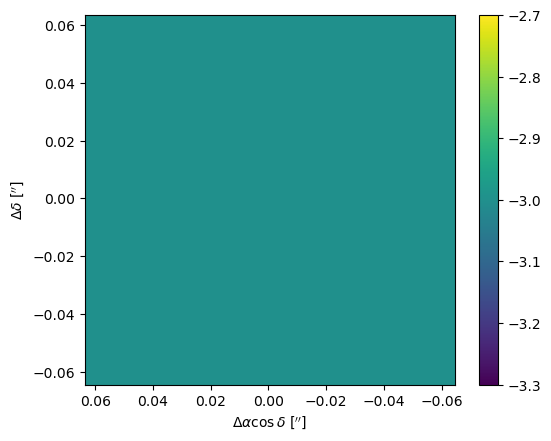

In [67]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(bcube_numpy),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im)

A blank image is not that exciting, but hopefully this demonstrates the state of the parameters at the start of optimization.

Because we'll want to compute a clean set of gradient values in a later step, we "zero out" any gradients attached to the tensor components so that they aren't counted twice.

In [68]:
rml.zero_grad()

Most modules in MPoL are designed to work in a "feed forward" manner, which means base parameters are processed through the network to predict model visibilites for comparison with data. We can calculate the full visibility cube corresponding to the current pixel values of the {class}`mpol.images.BaseCube`.

In [69]:
vis = rml()
print(vis)

tensor([[[ 7.8985e-04+0.0000e+00j,  3.0956e-06+7.5992e-08j,
          -3.0900e-06-1.5180e-07j,  ...,
           3.0807e-06-2.2724e-07j, -3.0900e-06+1.5180e-07j,
           3.0956e-06-7.5992e-08j],
         [ 3.0956e-06+7.5992e-08j,  1.2125e-08+5.9566e-10j,
          -1.2096e-08-8.9223e-10j,  ...,
           1.2096e-08-5.9422e-10j, -1.2125e-08+2.9765e-10j,
           1.2140e-08-9.3132e-16j],
         [-3.0900e-06-1.5180e-07j, -1.2096e-08-8.9223e-10j,
           1.2059e-08+1.1877e-09j,  ...,
          -1.2096e-08+2.9693e-10j,  1.2118e-08+2.3283e-16j,
          -1.2125e-08-2.9765e-10j],
         ...,
         [ 3.0807e-06-2.2724e-07j,  1.2096e-08-5.9422e-10j,
          -1.2096e-08+2.9693e-10j,  ...,
           1.1950e-08-1.7727e-09j, -1.2008e-08+1.4811e-09j,
           1.2052e-08-1.1870e-09j],
         [-3.0900e-06+1.5180e-07j, -1.2125e-08+2.9765e-10j,
           1.2118e-08+2.3283e-16j,  ...,
          -1.2008e-08+1.4811e-09j,  1.2059e-08-1.1877e-09j,
          -1.2096e-08+8.9223e-10j],
 

Of course, these aren't that exciting since they just reflect the constant value image.

But, exciting things are about to happen! We can calculate the loss between these model visibilities and the data

In [70]:
# calculate a loss
loss = losses.r_chi_squared_gridded(vis, dset)
print(loss.item())

26879.644228709956


and then we can calculate the gradient of the loss function with respect to the parameters

In [71]:
loss.backward()

We can even visualize what the gradient of the {class}`mpol.images.BaseCube` looks like (using a similar ``.detach()`` call as before)

/var/folders/mx/gllymv0j649_27tvhjbp4ryr0000gn/T/ipykernel_68923/719109660.py:11: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


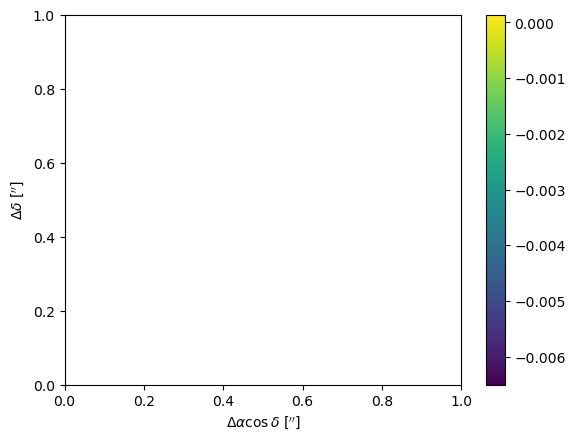

In [72]:
im = ax.imshow(
    np.squeeze(
        utils.packed_cube_to_sky_cube(rml.bcube.base_cube.grad).detach().numpy()
    ),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im)

The gradient image points in the direction of lower loss values. So the final step is to add the gradient image to the base image in order to advance base parameters in the direction of the minimum loss value. This process is called gradient descent, and can be extremely useful for optimizing large dimensional parameter spaces (like images). The optimizer carries out the addition of the gradient

In [73]:
optimizer.step()

In [74]:
rml.state_dict()

OrderedDict([('bcube.base_cube',
              tensor([[[191.0682, 190.9291, 190.7718,  ..., 191.3625, 191.2936, 191.1915],
                       [190.8279, 190.7539, 190.6613,  ..., 190.9351, 190.9259, 190.8866],
                       [190.4644, 190.4560, 190.4275,  ..., 190.3787, 190.4319, 190.4572],
                       ...,
                       [191.0136, 190.6795, 190.3227,  ..., 191.8371, 191.6040, 191.3245],
                       [191.1656, 190.8966, 190.6075,  ..., 191.8178, 191.6369, 191.4148],
                       [191.1822, 190.9781, 190.7555,  ..., 191.6580, 191.5319, 191.3689]]])),
             ('conv_layer.m.weight',
              tensor([[[[0.0625, 0.1250, 0.0625],
                        [0.1250, 0.2500, 0.1250],
                        [0.0625, 0.1250, 0.0625]]]])),
             ('conv_layer.m.bias', tensor([0.])),
             ('icube.packed_cube',
              tensor([[[0.0486, 0.0486, 0.0486,  ..., 0.0486, 0.0486, 0.0486],
                       [0.0486, 0

We can see that the parameter values have changed

as has the base image

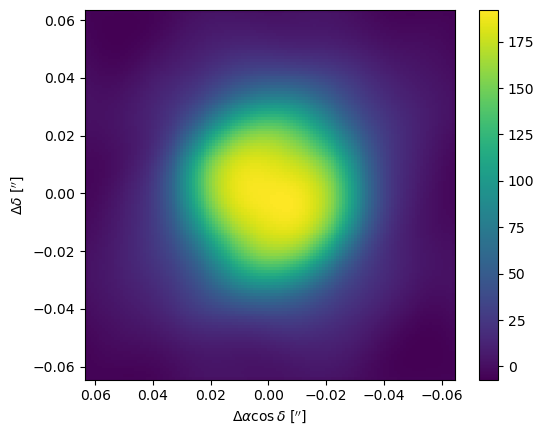

In [75]:
fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    np.squeeze(utils.packed_cube_to_sky_cube(rml.bcube.base_cube).detach().numpy()),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im)


## Iterating the training Loop

Now that we've covered how to use gradient descent to optimize a set of image parameters, let's wrap these steps into a training loop and iterate a few hundred times to converge to a final product.

In addition to the steps just outlined, we'll also track the loss values as we optimize.

In [76]:
%%time

loss_tracker = []

for i in range(3000):
    rml.zero_grad()

    # get the predicted model
    vis = rml()

    # calculate a loss
    loss = losses.r_chi_squared_gridded(vis, dset)

    loss_tracker.append(loss.item())

    # calculate gradients of parameters
    loss.backward()

    # update the model parameters
    optimizer.step()

CPU times: user 12.8 s, sys: 28.1 s, total: 40.8 s
Wall time: 4.46 s


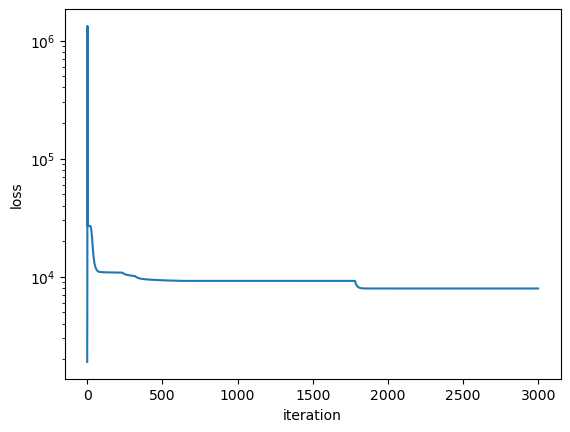

In [77]:
fig, ax = plt.subplots(nrows=1)
ax.plot(loss_tracker)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
plt.yscale("log")

and we see that we've reasonably converged to a set of parameters without much further improvement in the loss value.

## Visualizing the image

Let's visualize the final image product. The bounds for `matplotlib.pyplot.imshow` are available in the `img_ext` parameter.


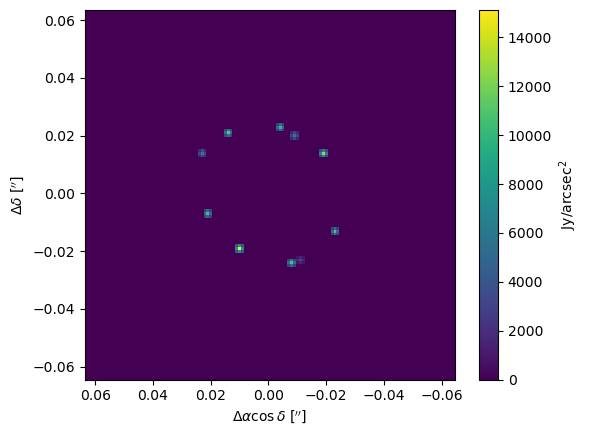

In [78]:
# let's see what one channel of the image looks like
fig, ax = plt.subplots(nrows=1)
img_cube = rml.icube.sky_cube.detach().numpy()
im = ax.imshow(
    np.squeeze(img_cube),
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im, label=r"Jy/$\mathrm{arcsec}^2$")

And there you have it, an image optimized to fit the data. To be honest, the results aren't great---that's because we've used minimal regularization in the form of the functional basis set we chose that automatically enforced image positivity (see the {class}`mpol.images.BaseCube` documentation). Otherwise, our only contribution to the loss function is the data likelihood. This means it's easy for the lower signal-to-noise visibilities at longer baselines to dominate the image appearance (not unlike CLEAN images made with "uniform" weighting) and there is high "noise" in the image.


## Visualizing the residuals

We started this tutorial with a collection of visibility data---the complex-valued samples of the Fourier transform of the true sky brightness. We used the forward-modeling capabilities of MPoL and Pytorch to propose image-plane models of the true sky brightness and then used the Fast Fourier Transform to convert these into model visibilities. These model visibilities were compared against the data visibilities using the negative log likelihood loss function and (optionally) additional losses calculated using regularizers. We then used the Pytorch autodifferentiation machinery to calculate derivatives of this loss function space and evolved the model of the sky brightness until the loss function was minimized. At the end of this process, we are left with an image-plane model that produces the minimum loss function values when compared against the data visibilities and any regularizers.

It nearly always worthwhile to visualize the residuals, defined as

$$
\mathrm{residuals} = \mathrm{data} - \mathrm{model}
$$

For speed reasons, the {class}`mpol.precomposed.GriddedNet` does not work with the original data visibilities directly, but instead uses an averaged version of them in {class}`~mpol.datasets.GriddedDataset`. To calculate model visibilities corresponding to the original $u,v$ points of the dataset,

In [79]:
from mpol import utils
# note the NuFFT expects a "packed image cube," as stored in ImageCube.cube
vis_model = rml.predict_loose_visibilities(torch.as_tensor(uu), torch.as_tensor(vv))
vis_model = utils.torch2npy(vis_model)
# convert from Pytorch to numpy, remove channel dimension
vis_model = np.squeeze(vis_model)


and then use these model visibilities to calculate residual visibilities

In [80]:
vis_resid = data - vis_model

There are many ways we could visualize these residuals. The simplest type of visualization is to examine the scatter of the residuals relative to their expected standard deviation (given by their thermal weights).

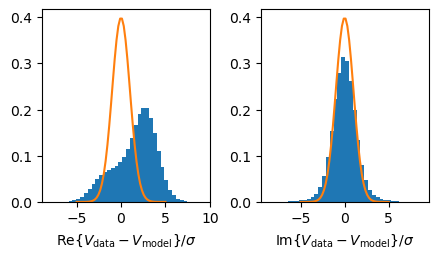

In [81]:
sigmas = np.sqrt(1/weight)
resid_real = np.real(vis_resid) / sigmas
resid_imag = np.imag(vis_resid) / sigmas


def gaussian(x, sigma=1):
    r"""
    Evaluate a reference Gaussian as a function of :math:`x`

    Args:
        x (float): location to evaluate Gaussian

    The Gaussian is defined as

    .. math::

        f(x) = \frac{1}{\sqrt{2 \pi}} \exp \left ( -\frac{x^2}{2}\right )

    Returns:
        Gaussian function evaluated at :math:`x`
    """
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (x / sigma) ** 2)


fig, ax = plt.subplots(ncols=2, figsize=(5, 2.5))

xs = np.linspace(-5, 5)

ax[0].hist(resid_real, density=True, bins=40)
ax[1].hist(resid_imag, density=True, bins=40)

ax[0].set_xlabel(
    r"$\mathrm{Re} \{ V_\mathrm{data} - V_\mathrm{model} \} / \sigma$"
)

ax[1].set_xlabel(
    r"$\mathrm{Im} \{ V_\mathrm{data} - V_\mathrm{model} \} / \sigma$"
)

for a in ax.flatten():
    a.plot(xs, gaussian(xs))

fig.subplots_adjust(wspace=0.3)

If our model is good, we would expect it to fit the signal contained in the data and the residuals contain only noise. As far as this plot is concerned, it appears as though we might have achieved this. However, most radio interferometric visibilities will be noise-dominated (even for high-signal to noise sources), and so a balanced residual scatter is easier to achieve than you might think. If the residuals were significantly over- or under-dispersed relative to their theoretical standard deviation, though, we should examine the calibration of the data (in particular, the calculation of the visibility weights).

A more useful diagnostic is to image the residual visibilities. We can do that by treating them as a new "dataset" and using the diagnostic imaging capabilities of {class}`mpol.gridding.DirtyImager`. Here we'll choose a Briggs "robust" value of 0.0, but you are free to image the residual visibilities with whatever weighting makes sense for your science application. When doing this type of residual visualization, we recommend specifying the units of the dirty image using `unit="Jy/arcsec^2"`, which are the natural units of MPoL images.

### Dirty Image Units
As discussed in the [Diagnostic Images](gridder.md) tutorial, the intensity units of the dirty image are technically undefined. When we specify `unit="Jy/arcsec^2"` the {class}`~mpol.gridding.DirtyImager` tries to estimate the volume of the dirty beam and convert the dirty image into something with well-defined surface brightness units. This operation is inherently ill-defined, but it is still useful. For more details on the ill-defined units of the dirty image (i.e., "Jy/dirty beam"), see footnote 4 of Chapter 3.2 of Daniel Briggs' [Ph.D. thesis](http://www.aoc.nrao.edu/dissertations/dbriggs/) or the discussion in [Czekala et al. 2021b](https://ui.adsabs.harvard.edu/abs/2021ApJS..257....2C/abstract).



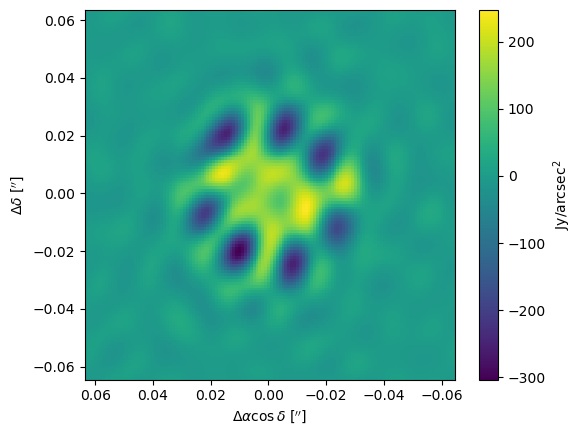

In [82]:
imager = gridding.DirtyImager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=np.real(vis_resid),
    data_im=np.imag(vis_resid),
)

img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0, unit="Jy/arcsec^2")

fig, ax = plt.subplots(nrows=1)
im = ax.imshow(
    img[0],
    origin="lower",
    interpolation="none",
    extent=rml.icube.coords.img_ext,
)
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.colorbar(im, label=r"Jy/$\mathrm{arcsec}^2$");

We see that the residual image appears to be mostly noise, though with some low-frequency spatial structure to the image. This suggests that our model has done a reasonable job of capturing the *signal* in the data. But, there is still obvious room for improvement in regularizing some of the noiser features. In the following tutorials we'll examine how to set up additional regularizer terms that will yield more desireable image characteristics.

Hopefully this tutorial has demonstrated the core concepts of synthesizing an image with MPoL. If you have any questions about the process, please feel free to reach out and start a [GitHub discussion](https://github.com/MPoL-dev/MPoL/discussions). If you spot a bug or have an idea to improve these tutorials, please raise a [GitHub issue](https://github.com/MPoL-dev/MPoL/issues) or better yet submit a pull request.